<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/RTM_Machine_Learning_vs_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview of the steps:

1) Generate prosail hyperspectral data with 5 varying traits, one observation angle and one sun position. \\

2) Convert them to Sentinel 2A (or B, or a mixture of both) spectral resolution \\
3) Train Machine learning (ANN, RF and GPR) and test \\
4) Test optimization algorithms: Grad desc; Swarm and an evolutionary algorithm \\
5) Generate plots and save \\


In [129]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu


In [0]:
#importing packages

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#machine learning packages are imported later, nearer to the model

Step 1: Generating data \\

First we define a function that converts the input hyperspectral data into Sentinel 2 A (or B) data. The Spectral Response Function for this can be obtained from ESA at: [ESA Sentinel 2 SRF](https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses). \\

Once this is downloaded, one of the sheets has the SRF of S2A and the other S2B and by copying this to a new CSV file, as is, then we have the necessary file for running this section. An image example of how the csv should look like can be seen in [link](https://www.dropbox.com/s/sb25k5ikt3q0bfx/CSV%20example.png?dl=0) \\

The method for generating S2 responses is the Weighted arithmetic mean (check [wikipedia](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean)): [Formula](https://www.dropbox.com/s/a3ye7ch2puatv5q/WeightedMean.png?dl=0) \\







First we define a function that takes as input a path to the CSV described above and an hyperpectral spectra (numpy array) as generated by PROSAIL

In [0]:
def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/content/S2_Response.csv"

Now we generate the trait space: 
1.  3000 samples which will be used for training the various machine learning 
2.  1000 samples which will be sidelined and used for validation



In [0]:
#number of samples
train_n = 3000
valid_n = 1000
n_traits=5 #I will test on 5 varying traits: cab, car, cw,cm,lai

#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
LHS_train = lhsmdu.createRandomStandardUniformMatrix(n_traits,train_n ) #the package has a more advanced method but it is too slow to process
LHS_valid = lhsmdu.createRandomStandardUniformMatrix(n_traits,valid_n ) 

#Here we set the max values of the traits. These are to be multiplied by an array between [0,1],
#thus there is a risk of very low values of the traits causing erroneous ouput from prosail. 

#max_n=1 #this value should go from 1 to 2, so i make it change from 0 to 1 here and then add 1 later
max_cab=79. #add 1
max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.008 #add 0.001 
max_cm=0.008 #0.001
max_lai = 9.9 #add 0.1


#in here I create a custom call for prosail, this allows me to more easily control the default values
def custom_prosail(cab,car,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.2
  cbrown=0.01
  typelidf=1
  lidfa = -0.35 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters
  #sun and viewing angle
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,hspot,tts,tto,psi,
                                 typelidf, #lidfb=-0.15,
                                 factor='SDR', rsoil=1., psoil=1.)
  return(rho_out)

pd_train_traits = pd.DataFrame.transpose(pd.DataFrame(LHS_train))
pd_train_traits.columns = ["cab","car","cw","cm","lai"]
pd_valid_traits = pd.DataFrame.transpose(pd.DataFrame(LHS_valid))
pd_valid_traits.columns = ["cab","car","cw","cm","lai"]

#this addition is to avoid extreme values that can perhaps cause prosail failure
pd_train_traits["car"]=pd_train_traits["car"]*max_car+1 
pd_train_traits["cab"]=pd_train_traits["cab"]*max_cab+1
pd_train_traits["cw"] =pd_train_traits["cw"]*max_cw+.001
pd_train_traits["cm"] =pd_train_traits["cm"]*max_cm+.001
pd_train_traits["lai"]=pd_train_traits["lai"]*max_lai+.25
#pd_train_traits["n"]=pd_train_traits["n"]*max_n+1
#pd_train_traits["car"]=pd_train_traits["cab"]*max_car+1 #changed here to cab to ensure that it is 100% autocorrelated 
#pd_train_traits["cbrown"]=pd_train_traits["cbrown"]*max_cbrown+ 0.01

pd_valid_traits["car"]=pd_valid_traits["car"]*max_car+1 
pd_valid_traits["cab"]=pd_valid_traits["cab"]*max_cab+1
pd_valid_traits["cw"]=pd_valid_traits["cw"]*max_cw+.001
pd_valid_traits["cm"]=pd_valid_traits["cm"]*max_cm+.001
pd_valid_traits["lai"]=pd_valid_traits["lai"]*max_lai+.25
#pd_valid_traits["n"]=pd_valid_traits["n"]*max_n+1
#pd_valid_traits["car"]=pd_valid_traits["cab"]*max_car+1 #changed here to cab to ensure that it is 100% autocorrelated
#pd_valid_traits["cbrown"]=pd_valid_traits["cbrown"]*max_cbrown+ 0.01


Now we can finally loop to generate the PROSAIL output, first in hyperspectral and then in sentinel radiometric resolution

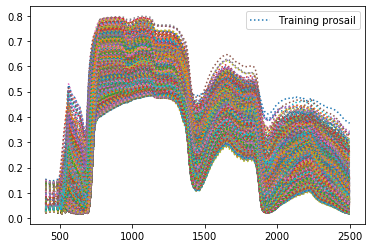

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


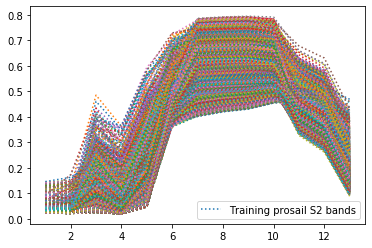

training dataset s2 shape
(3000, 13)


In [133]:
#THIS SECTION GENERATES THE TRAINING DATA

#lets generate a spectra table
#aux for x axis plotting help
x = np.arange(400,2501)
x[-1]

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_train_traits)):
    #print(i)

    #n_t = pd_train_traits["n"][i]
    cab_t = pd_train_traits["cab"][i]
    car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = pd_train_traits["cw"][i]
    cm_t = pd_train_traits["cm"][i]
    lai_t = pd_train_traits["lai"][i]


    if k == 1:
      tr_rho_s = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      plt.plot ( x, tr_rho_t, ':')

    
    k = k+1

plt.show()


#now, we convert the above for sentinel 2 A resolution
#aux for x axis
x_s2 = np.arange(1,14)
print(x_s2)

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_train_traits)):
    #print(i)

    #n_t = pd_train_traits["n"][i]
    cab_t = pd_train_traits["cab"][i]
    car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = pd_train_traits["cw"][i]
    cm_t = pd_train_traits["cm"][i]
    lai_t = pd_train_traits["lai"][i]

    if k == 1:
      tr_rho_s_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      tr_rho_s_s2 = Prosail2S2(filepath,tr_rho_s_s2)

      plt.plot ( x_s2, tr_rho_s_s2, ':', label="Training prosail S2 bands")
      plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      tr_rho_t_s2 = Prosail2S2(filepath,tr_rho_t_s2)

      tr_rho_s_s2 = np.vstack((tr_rho_s_s2,tr_rho_t_s2))
      plt.plot ( x_s2, tr_rho_t_s2, ':')

    
    k = k+1

plt.show()
#the order f the bands is: 
#S2A_SR_AV_B1	S2A_SR_AV_B2	S2A_SR_AV_B3	
#S2A_SR_AV_B4	S2A_SR_AV_B5	S2A_SR_AV_B6	
#S2A_SR_AV_B7	S2A_SR_AV_B8	S2A_SR_AV_B8A	
#S2A_SR_AV_B9	S2A_SR_AV_B10	S2A_SR_AV_B11	
#S2A_SR_AV_B12
print("training dataset s2 shape")
print(tr_rho_s_s2.shape)


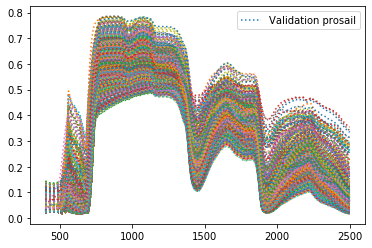

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


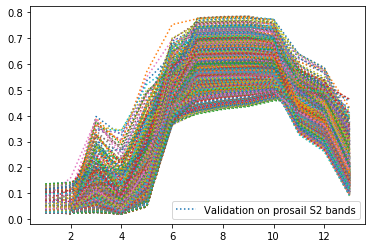

training dataset s2 shape
(1000, 13)


In [134]:
#now we do the same for the validation dataset

#THIS SECTION GENERATES THE VALIDATION DATA

#lets generate a spectra table
#aux for x axis plotting help
x = np.arange(400,2501)
x[-1]

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_valid_traits)):
    #print(i)

    #n_t = pd_valid_traits["n"][i]
    cab_t = pd_valid_traits["cab"][i]
    car_t = pd_valid_traits["car"][i]
    #cbrown_t = pd_valid_traits["cbrown"][i]
    cw_t = pd_valid_traits["cw"][i]
    cm_t = pd_valid_traits["cm"][i]
    lai_t = pd_valid_traits["lai"][i]


    if k == 1:
      vl_rho_s = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      plt.plot ( x, vl_rho_s, ':', label="Validation prosail")
      plt.legend(loc='best')
      
    if k > 1:
      vl_rho_t = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      vl_rho_s = np.vstack((vl_rho_s,vl_rho_t))
      plt.plot ( x, vl_rho_t, ':')

    
    k = k+1

plt.show()


#now, we convert the above for sentinel 2 A resolution
#aux for x axis
x_s2 = np.arange(1,14)
print(x_s2)

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_valid_traits)):
    #print(i)

    #n_t = pd_valid_traits["n"][i]
    cab_t = pd_valid_traits["cab"][i]
    car_t = pd_valid_traits["car"][i]
    #cbrown_t = pd_valid_traits["cbrown"][i]
    cw_t = pd_valid_traits["cw"][i]
    cm_t = pd_valid_traits["cm"][i]
    lai_t = pd_valid_traits["lai"][i]

    if k == 1:
      vl_rho_s_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      vl_rho_s_s2 = Prosail2S2(filepath,vl_rho_s_s2)

      plt.plot ( x_s2, vl_rho_s_s2, ':', label="Validation on prosail S2 bands")
      plt.legend(loc='best')
      
    if k > 1:
      vl_rho_t_s2 = custom_prosail(cab_t,car_t,cw_t,cm_t,lai_t)
      vl_rho_t_s2 = Prosail2S2(filepath,vl_rho_t_s2)

      vl_rho_s_s2 = np.vstack((vl_rho_s_s2,vl_rho_t_s2))
      plt.plot ( x_s2, vl_rho_t_s2, ':')

    
    k = k+1

plt.show()

#the order f the bands is: 
#S2A_SR_AV_B1	S2A_SR_AV_B2	S2A_SR_AV_B3	
#S2A_SR_AV_B4	S2A_SR_AV_B5	S2A_SR_AV_B6	
#S2A_SR_AV_B7	S2A_SR_AV_B8	S2A_SR_AV_B8A	
#S2A_SR_AV_B9	S2A_SR_AV_B10	S2A_SR_AV_B11	
#S2A_SR_AV_B12
print("training dataset s2 shape")
print(vl_rho_s_s2.shape)



Now all that is left is removing the unused bands

In [0]:
#the order f the bands is: 
#S2A_SR_AV_B1	S2A_SR_AV_B2	S2A_SR_AV_B3	
#S2A_SR_AV_B4	S2A_SR_AV_B5	S2A_SR_AV_B6	
#S2A_SR_AV_B7	S2A_SR_AV_B8	S2A_SR_AV_B8A	
#S2A_SR_AV_B9	S2A_SR_AV_B10	S2A_SR_AV_B11	
#S2A_SR_AV_B12

#we pick only the bands at 20m resolution - i reckon it is actually peaceful to use everything.. 
s2_train_df = tr_rho_s_s2[:,[1,2,3,4,5,6,8,11,12]]
s2_valid_df = vl_rho_s_s2[:,[1,2,3,4,5,6,8,11,12]]

Now that we have generated a training and validation dataset lets do the machine learning part. 


First we train a ANN (with the same structure as i did for ESA OPEN SCIENCE), then a Random Forest and finally a GPR. 


For now, i will just test against the validation data - no kfolding. 

Training the Artificial neural network:

package: sklearn
link to function: [ANN](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

Links of interest: \\
[keras layers core](https://keras.io/layers/core/) \\
[keras loss functions](https://keras.io/losses/) \\
[keras optimizers](https://keras.io/optimizers/) \\
[example](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) \\

In [0]:
#machine learning stuff
from sklearn.neural_network import MLPRegressor as ANN_reg #this is a simpler neural network package

from keras.models import Sequential
from keras.layers import Dense
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#ignore the warning for now

In [0]:
#creating the ANN and fitting
ann_ml = Sequential()
#ann_ml.add(Dense(9, input_dim=9, activation='linear'))
ann_ml.add(Dense(10, input_dim=9, activation='tanh'))
ann_ml.add(Dense(6, activation='tanh'))
ann_ml.add(Dense(5, activation='relu')) #indeed this ha to be added in this case without any activ function, the R script added this on its own
#model.add(Dense(1, activation='sigmoid'))

# compile the keras model
ann_ml.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


#type(pd_train_traits.iloc[:,:].values)
#type(s2_train_df)
#pd_train_traits.iloc[:,:].values.shape
from sklearn.preprocessing import MinMaxScaler #this is to standardize the input data [not used for now]

#preparing data for ANN
X_ann = s2_train_df
Y_ann = pd_train_traits.iloc[:,:].values #converts from a panda table to a numpy

scaler = MinMaxScaler()#lets rescale the input
scaler.fit(Y_ann)
Y_ann_norm = scaler.transform(Y_ann)

ann_ml.fit(X_ann,Y_ann_norm,epochs=1500,verbose=0) #this hides the output spam


In [0]:
#we can now store the outputs of the neural network
Y_ann_pred = pd.DataFrame(scaler.inverse_transform(ann_ml.predict(s2_valid_df)))
Y_ann_pred.columns = ["cab","car","cw","cm","lai"]
#Y_ann_pred

Now we train the random forest

[scikit randf](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)



In [139]:
#setting up variables
X_rf=s2_train_df
Y_rf=pd_train_traits.iloc[:,:].values

# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 

rf_ml = RandomForestRegressor(n_estimators=100,random_state=0,
                              min_samples_leaf=5,min_samples_split=10,verbose=1)

rf_ml.fit(X_rf,Y_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=1, warm_start=False)

In [140]:
#we can now store the outputs of the random forest
Y_rf_pred = pd.DataFrame(rf_ml.predict(s2_valid_df))
Y_rf_pred.columns = ["cab","car","cw","cm","lai"]
#Y_rf_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Now we go for the gaussian processes regression




In [141]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

#initializing the model
gpr_ml = GaussianProcessRegressor(n_restarts_optimizer=50,
                                        #normalize_y=True,
                                        random_state=0)
#no reason to create the variables again
gpr_ml.fit(X_rf,Y_rf)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=50, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [0]:
#we can now store the outputs of the gaussian processes regression
Y_gpr_pred = pd.DataFrame(gpr_ml.predict(s2_valid_df))
Y_gpr_pred.columns = ["cab","car","cw","cm","lai"]
#Y_rf_pred


Let's look at how the each model predicts the validation data that i left on the side


[helper link](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

Text(0.5, 0, 'Reference')

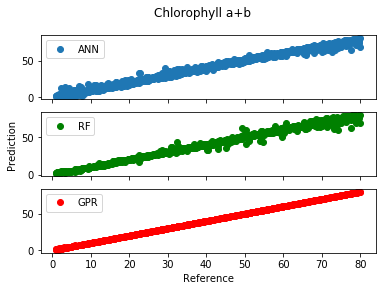

In [169]:
#plotting cab
fig, axs = plt.subplots(3,1,sharex=True)
fig.suptitle('Chlorophyll a+b')

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["cab"],Y_ann_pred["cab"],"o",label="ANN")
axs[0].legend(loc="upper left")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["cab"],Y_rf_pred["cab"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_ylabel("Prediction")
axs[2].plot(pd_valid_traits["cab"],Y_gpr_pred["cab"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")


Text(0.5, 0, 'Reference')

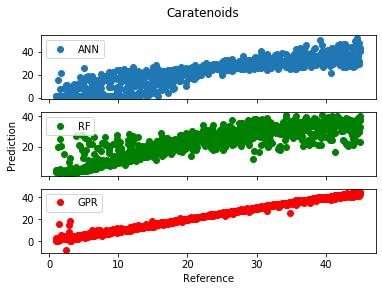

In [170]:
#plotting car
fig, axs = plt.subplots(3,1,sharex=True)
fig.suptitle('Caratenoids')

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["car"],Y_ann_pred["car"],"o",label="ANN")
axs[0].legend(loc="upper left")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["car"],Y_rf_pred["car"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_ylabel("Prediction")
axs[2].plot(pd_valid_traits["car"],Y_gpr_pred["car"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")

Text(0.5, 0, 'Reference')

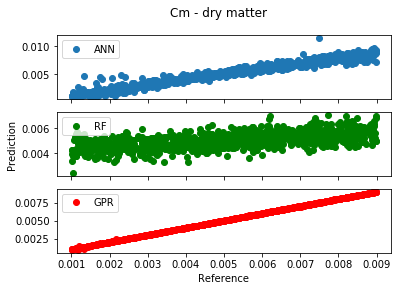

In [172]:
#plotting cm
fig, axs = plt.subplots(3,1,sharex=True)
fig.suptitle('Cm - dry matter')

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["cm"],Y_ann_pred["cm"],"o",label="ANN")
axs[0].legend(loc="upper left")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["cm"],Y_rf_pred["cm"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_ylabel("Prediction")
axs[2].plot(pd_valid_traits["cm"],Y_gpr_pred["cm"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")

Text(0.5, 0, 'Reference')

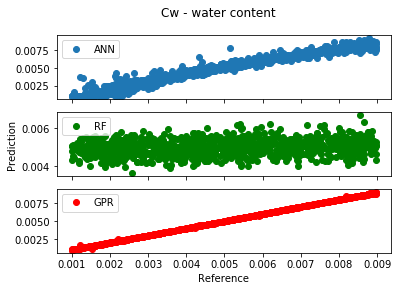

In [173]:
#plotting cm
fig, axs = plt.subplots(3,1,sharex=True)
fig.suptitle('Cw - water content')

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["cw"],Y_ann_pred["cw"],"o",label="ANN")
axs[0].legend(loc="upper left")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["cw"],Y_rf_pred["cw"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_ylabel("Prediction")
axs[2].plot(pd_valid_traits["cw"],Y_gpr_pred["cw"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")

Text(0.5, 0, 'Reference')

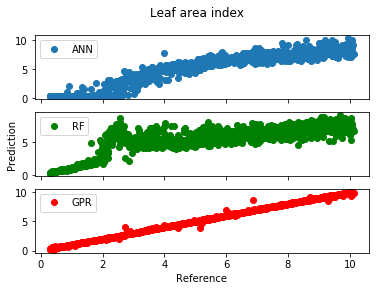

In [174]:
#plotting cm
fig, axs = plt.subplots(3,1,sharex=True)
fig.suptitle('Leaf area index')

#plt.subplot(3,1,1)
axs[0].plot(pd_valid_traits["lai"],Y_ann_pred["lai"],"o",label="ANN")
axs[0].legend(loc="upper left")
#axs[0].set(ylabel="Prediction")
axs[1].plot(pd_valid_traits["lai"],Y_rf_pred["lai"],"o",color="green",label="RF")
axs[1].legend(loc="upper left")
axs[1].set_ylabel("Prediction")
axs[2].plot(pd_valid_traits["lai"],Y_gpr_pred["lai"],"o",color="red",label="GPR")
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Reference")
#axs[0].ylabel("ANN")